# LUNA16 Pre-processing

This is the [**LU**ng **N**odule **A**nalysis](https://luna16.grand-challenge.org) script for reading in the CT scans and extracting image patches around the candidate regions of interest.

In [1]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import ntpath
%matplotlib inline

## Data directory

In [68]:
DATA_DIR = "/Volumes/data/tonyr/dicom/LUNA16/"
img_file = 'subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074.mhd'
#img_file = 'subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476.mhd'
#img_file = 'subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.282512043257574309474415322775.mhd'  # TODO:  Check this one
#img_file = 'subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.134370886216012873213579659366.mhd'
#img_file = 'subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.922852847124879997825997808179.mhd'
#img_file= 'subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.336894364358709782463716339027.mhd'
#img_file = 'subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.231834776365874788440767645596.mhd'
#img_file = 'subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.208737629504245244513001631764.mhd'
cand_path = 'CSVFILES/candidates_V2.csv'

In [69]:
subjectName = ntpath.splitext(ntpath.basename(img_file))[0]

dfAnnotations = pd.read_csv(DATA_DIR+'CSVFILES/annotations.csv')

In [70]:
dfAnnotations[dfAnnotations['seriesuid']==subjectName]

,seriesuid,coordX,coordY,coordZ,diameter_mm
454,1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640...,54.577717,137.279089,-626.592114,13.962632
455,1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640...,109.434156,229.616341,-722.083867,6.401625
456,1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640...,96.375149,213.080048,-613.536361,4.784887


In [71]:
dfCandidates = pd.read_csv(DATA_DIR+cand_path)

In [72]:
df1 = dfCandidates[dfCandidates['seriesuid'] ==subjectName]
df1[df1['class']==1]

,seriesuid,coordX,coordY,coordZ,class
285808,1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640...,53.089339,137.875900,-627.141098,1
285980,1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640...,108.723986,229.212418,-721.720158,1
286387,1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640...,95.399010,212.384011,-613.030292,1


## Image Normalization (?)

CT and Xrays can be segmented by first converting the pixel value to [Hounsfield Units](https://en.wikipedia.org/wiki/Hounsfield_scale). 

However, I am not sure we actually want to do this. Calcified nodules often turn out to be benign. So removing HU above +500 or even +3000 might not be a good idea (?)

Substance |	Hounsfield Units (HU)
-------- | -----
Air	| −1000
Lung	| -700 to −600[2]
Fat	| −120 to −90[3]
Water	| 0
Urine	| -5 to +15[3]
Bile	| -5 to +15[3]
CSF	| +15
Kidney	|+20 to +45[3]
Liver	| 60 ± 6[5]
Lymph nodes	| +10 to +20[6]
Blood	| +30 to +45
Muscle	| +35 to +55[3]
White matter |	+20 to +30
Grey matter	| +37 to +45
Soft Tissue, Contrast	| +100 to +300
Bone	| +200 (craniofacial bone), +700 (cancellous bone) to +3000 (cortical bone)


In [44]:
"""
Normalize pixel depth into Hounsfield units (HU)

This tries to get all pixels between -1000 and 400 HU.
All other HU will be masked.

"""
def normalizePlanes(npzarray):
     
    maxHU = 400.
    minHU = -1000.
 
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

## Extract ROI image patches for candidates

Procedure:
1. Load the .mhd file for the CT image volume. This is a 3D image.
2. Load the candidates_V2.csv file to specify the centers for our regions of interest (ROI).  There are usually several hundred ROIs per CT, but only 1-5 of them have been labeled as true nodules by the radiologists.
3. Save a patch (32 x 32 pixel) around the center of the candidate location. Currently, they just extract a transverse (2D image at a fixed slice #). TODO: Let's think about extracting a 3D volume for our patch instead.

In [45]:
def extractCandidates(img_file):
    
    # Get the name of the file
    subjectName = ntpath.splitext(ntpath.basename(img_file))[0]  # Strip off the .mhd extension
    
    # Read the list of candidate ROI
    dfCandidates = pd.read_csv(DATA_DIR+cand_path)
    
    numCandidates = dfCandidates[dfCandidates['seriesuid']==subjectName].shape[0]
    print('There are {} candidate nodules in this file.'.format(numCandidates))
    
    numNonNodules = sum(dfCandidates[dfCandidates['seriesuid']==subjectName]['class'] == 0)
    numNodules = sum(dfCandidates[dfCandidates['seriesuid']==subjectName]['class'] == 1)
    print('{} are true nodules (class 1) and {} are non-nodules (class 0)'.format(numNodules, numNonNodules))
    
    # Read if the candidate ROI is a nodule (1) or non-nodule (0)
    candidateValues = dfCandidates[dfCandidates['seriesuid']==subjectName]['class'].values
    
    # Get the world coordinates (mm) of the candidate ROI center
    worldCoords = dfCandidates[dfCandidates['seriesuid']==subjectName][['coordX', 'coordY', 'coordZ']].values
    
    # Use SimpleITK to read the mhd image
    itkimage = sitk.ReadImage(DATA_DIR+img_file)
    
    # Get the real world origin (mm) for this image
    originMatrix = np.tile(itkimage.GetOrigin(), (numCandidates,1))  # Real world origin for this image (0,0)
    
    # Subtract the real world origin and scale by the real world (mm per pixel)
    # This should give us the X,Y,Z coordinates for the candidates
    candidatesPixels = (np.round(np.absolute(worldCoords - originMatrix) / itkimage.GetSpacing())).astype(int)
    
    candidatePatches = []
    candidateLabel = []
    
    imgAll = sitk.GetArrayFromImage(itkimage) # Read the image volume
    
    for candNum in range(numCandidates):
        
        #print('Extracting candidate patch #{}'.format(candNum))
        candidateVoxel = candidatesPixels[candNum,:]
        xpos = int(candidateVoxel[0])
        ypos = int(candidateVoxel[1])
        zpos = int(candidateVoxel[2])
        
        # Need to handle the candidates where the window would extend beyond the image boundaries
        windowSize = 32
        x_lower = np.max([0, xpos - windowSize])  # Return 0 if position off image
        x_upper = np.min([xpos + windowSize, itkimage.GetWidth()]) # Return  maxWidth if position off image
        
        y_lower = np.max([0, ypos - windowSize])  # Return 0 if position off image
        y_upper = np.min([ypos + windowSize, itkimage.GetHeight()]) # Return  maxHeight if position off image
         
        # SimpleITK is x,y,z. Numpy is z, y, x.
        imgPatch = imgAll[zpos, y_lower:y_upper, x_lower:x_upper]
        
        # Normalize to the Hounsfield units
        # TODO: I don't think we should normalize into Housefield units
        imgPatchNorm = imgPatch #normalizePlanes(imgPatch)
        
        candidatePatches.append(imgPatchNorm)  # Append the candidate image patches to a python list

    return candidatePatches, candidateValues

In [46]:
patchesArray, valuesArray = extractCandidates(img_file)

There are 326 candidate nodules in this file.
1 are true nodules (class 1) and 325 are non-nodules (class 0)


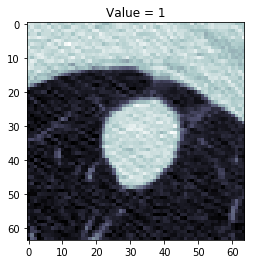

In [57]:
# Display the positive candidates (nodules)

numPositives = np.where(valuesArray==1)[0]

if (len(numPositives) > 1):
    plt.figure(figsize=(10,10))

for i, candidateNum in enumerate(numPositives):

    plt.subplot(len(numPositives),1,i+1)
    plt.imshow(patchesArray[candidateNum], cmap='bone');
    plt.title('Value = {}'.format(valuesArray[candidateNum]));

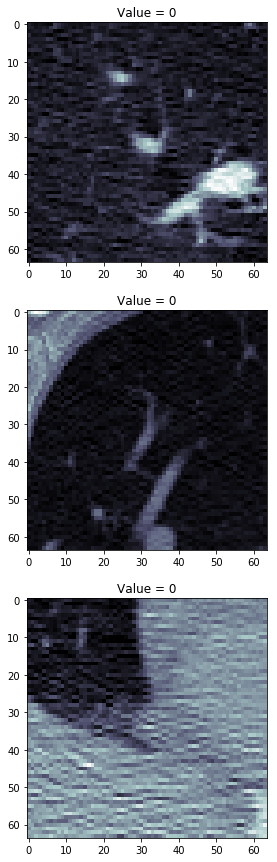

In [48]:
# Display three candidate non-nodules

numNegatives = np.where(valuesArray==0)[0]
plt.figure(figsize=(15,15))
for i, candidateNum in enumerate(numNegatives[:3]):

    plt.subplot(3,1,i+1)
    plt.imshow(patchesArray[candidateNum], cmap='bone');
    plt.title('Value = {}'.format(valuesArray[candidateNum]));